In [1]:
import sys 
sys.path.append('../Data_storage/')
sys.path.append('../Code_Base')

In [2]:
import os

In [3]:
from essential_imports import *


import pandas as pd
import numpy as np
import matplotlib as plt
import pandas_profiling
import warnings



In [4]:
from coin_information import *

In [5]:
from statsmodels.tsa.stattools import adfuller 

In [6]:
from matplotlib.pylab import rcParams 

In [7]:
warnings.filterwarnings('ignore')

## ML DS modules

In [8]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
ETH = []
for myf in open('../Data_storage/ETC_5min_Freq.txt'):
    ETH.append(myf.replace('\n',''))

In [21]:
ETH_Data = []
for E in ETH:
    E_Temp = pd.read_csv('../Data_storage/Coin_Data_5min/{0}.csv'.format(E))
    ETH_Data.append(E_Temp)

In [22]:
ETH_Data = pd.concat(ETH_Data)

In [23]:
ETH_Data['datetime_real'] = ETH_Data['date'].apply(lambda x: datetime.fromtimestamp(x))

In [24]:
ETH_Data = ETH_Data[ETH_Data['date'] != 0]

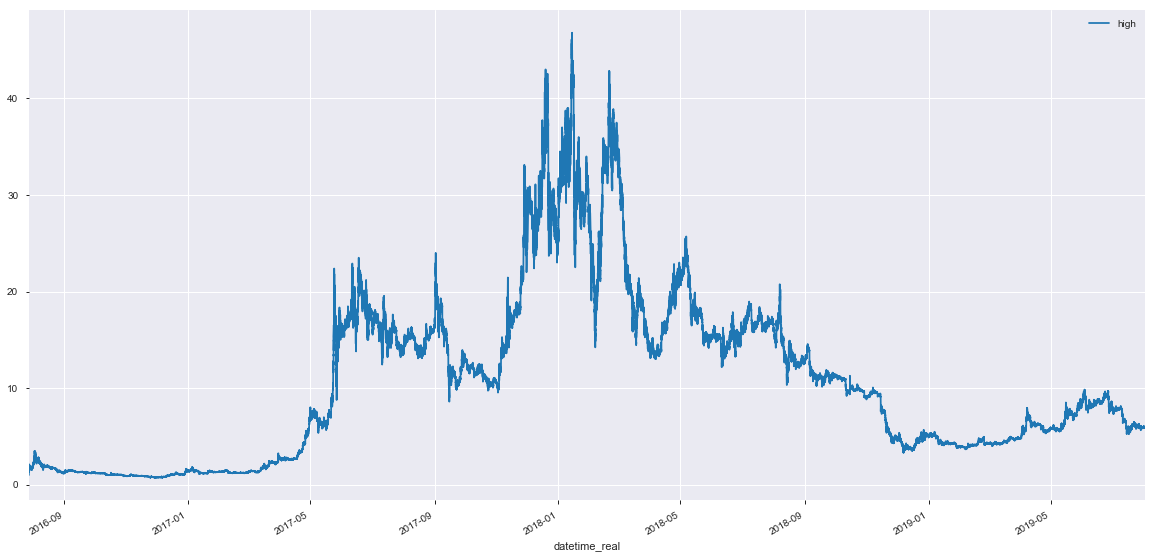

In [25]:
ETH_Data[['high','datetime_real']].set_index('datetime_real').plot(figsize= (20,10))

In [29]:
ETH_Data = ETH_Data.drop(columns = 'Unnamed: 0').drop_duplicates()

## Swing Analysis 

In [135]:
swing_ETH = ETH_Data[['high','close','low','datetime_real','volume']]#.groupby(pd.Grouper(key='datetime_real', freq= 'D'))

In [136]:
#swing_ETH.groupby(pd.Grouper(key = 'datetime_real', freq= 'H')

In [137]:
rolling_12Hour = 5*12*12

In [138]:
swing_ETH['close_rolling_{0}'.format(rolling_12Hour)] = swing_ETH['close'].rolling(window = rolling_12Hour).mean()

In [139]:
swing_ETH['from_RA'] = swing_ETH['close'] - swing_ETH['close_rolling_720']

In [140]:
swing_ETH['Percent_Difference'] = swing_ETH['from_RA']/swing_ETH['close_rolling_720'] * 100

In [141]:
swing_ETH['Percent_Difference_RA'] = swing_ETH['Percent_Difference'].rolling(window = 720).mean()

In [142]:
#swing_ETH[(swing_ETH['datetime_real'] >= '2017-01-01')].set_index('datetime_real')[['Percent_Difference_RA']].plot(figsize = (20,20))

In [143]:
swing_ETH['Bull_Bear'] = swing_ETH['Percent_Difference'].apply(lambda x : 'Bull' if x > 2 else 'Bear' if x < -2 else None)

In [144]:
swing_ETH['Bull_Bear'] = swing_ETH['Bull_Bear'].fillna(method = 'ffill')

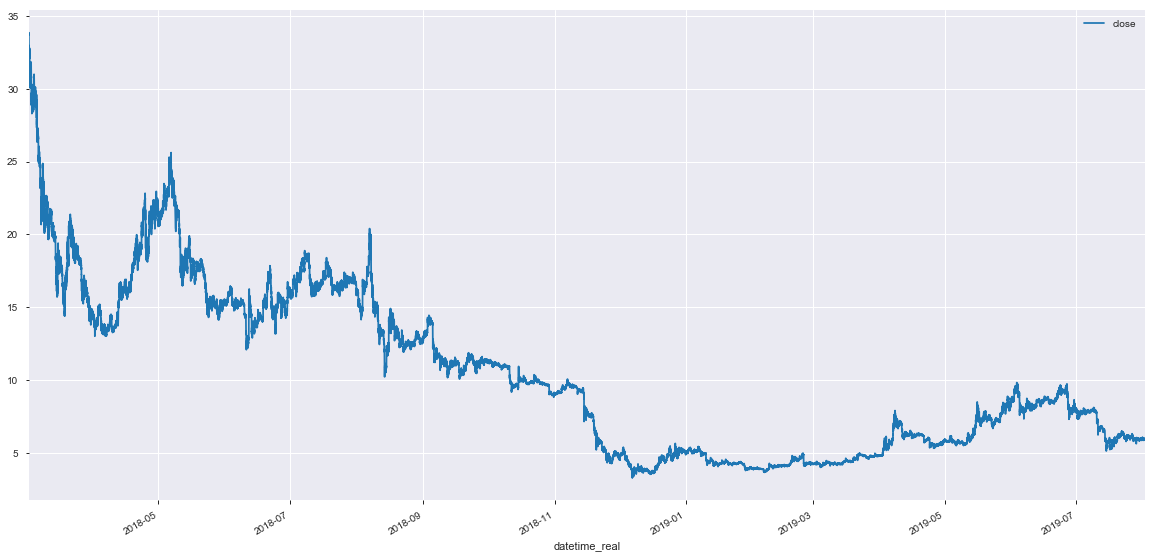

In [145]:
swing_ETH[swing_ETH['datetime_real'] > '2018-03-02'].set_index('datetime_real')[['close']].plot(figsize = (20,10))

In [147]:
swing_below_4percent = swing_ETH[(swing_ETH['Percent_Difference'] < -4) & (swing_ETH['volume'] > 2) ][['datetime_real']]

In [148]:
swing_below_4percent['Buy'] = 1

In [155]:
len(swing_ETH[(swing_ETH['Percent_Difference'] < -2) & (swing_ETH['volume'] > 2) ])

88285

In [114]:
len(swing_ETH)

316743

In [151]:
60928/316743

0.19235784216225774

10% time it dips below 2% of RA

In [152]:
swing_ETH = swing_ETH.merge(swing_below_4percent, on = 'datetime_real', how = 'left')

In [153]:
swing_ETH['Buy'] = swing_ETH['Buy'].fillna(0)

In [159]:
swing_ETH['Buy_shift'] = swing_ETH['Buy'].shift(-1)

In [161]:
swing_ETH['Group'] = swing_ETH['Buy'] - swing_ETH['Buy_shift']

In [166]:
Zero_to_One = swing_ETH[swing_ETH['Group'] == -1][['datetime_real','Group']]

In [169]:
Zero_to_One['Zero_to_One'] = Zero_to_One['Group'].cumsum()

In [167]:
One_to_Zero = swing_ETH[swing_ETH['Group'] == 1][['datetime_real','Group']]

In [171]:
One_to_Zero['One_to_Zero'] = One_to_Zero['Group'].cumsum()

In [175]:
Grouping  = pd.concat([One_to_Zero,Zero_to_One]).sort_values(by = 'datetime_real')

In [177]:
Grouping['New_Group'] = Grouping['Zero_to_One'].fillna(Grouping['One_to_Zero'])

In [180]:
swing_ETH = swing_ETH.merge(Grouping[['datetime_real','New_Group']], on = 'datetime_real', how= 'outer')

In [183]:
swing_ETH['New_Group_2'] = swing_ETH['New_Group'].fillna(method ='bfill')

In [190]:
highests =  swing_ETH.groupby(['New_Group_2'],as_index=False).agg({'high':'max'})

In [204]:
swing_ETH[swing_ETH['New_Group_2'] == -6927.0]

,high,close,low,datetime_real,volume,close_rolling_720,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2
315202,5.850000,5.850000,5.850000,2019-07-27 13:45:00,0.000000,6.097059,-0.247059,-4.052103,0.636892,Bear,0.0,0.0,0.0,NaN,-6927.0
315203,5.850000,5.850000,5.850000,2019-07-27 13:50:00,0.000000,6.096534,-0.246534,-4.043842,0.628261,Bear,0.0,0.0,0.0,NaN,-6927.0
315204,5.850000,5.850000,5.850000,2019-07-27 13:55:00,0.000000,6.096009,-0.246009,-4.035580,0.619637,Bear,0.0,0.0,0.0,NaN,-6927.0
315205,5.884077,5.872445,5.872445,2019-07-27 14:00:00,6.005400,6.095552,-0.223106,-3.660150,0.612117,Bear,0.0,0.0,0.0,NaN,-6927.0
315206,5.872445,5.872445,5.872445,2019-07-27 14:05:00,0.000000,6.095094,-0.222649,-3.652914,0.604599,Bear,0.0,0.0,0.0,NaN,-6927.0
315207,5.872445,5.872445,5.872445,2019-07-27 14:10:00,0.000000,6.094636,-0.222191,-3.645677,0.597085,Bear,0.0,0.0,0.0,NaN,-6927.0
315208,5.872856,5.872856,5.872856,2019-07-27 14:15:00,2.001800,6.094179,-0.221322,-3.631703,0.589584,Bear,0.0,0.0,0.0,NaN,-6927.0
315209,5.850001,5.850001,5.850001,2019-07-27 14:20:00,249.027084,6.093690,-0.243689,-3.999033,0.581568,Bear,0.0,0.0,0.0,NaN,-6927.0
315210,5.850001,5.850001,5.850001,2019-07-27 14:25:00,0.000000,6.093259,-0.243258,-3.992250,0.574513,Bear,0.0,0.0,0.0,NaN,-6927.0
315211,5.850001,5.850001,5.850001,2019-07-27 14:30:00,0.000000,6.092829,-0.242828,-3.985465,0.567461,Bear,0.0,0.0,0.0,NaN,-6927.0


In [205]:
swing_ETH.loc[swing_ETH.groupby(['New_Group_2']).high.idxmax()] # highest value within next groups

,high,close,low,datetime_real,volume,close_rolling_720,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2
315435,6.010000,6.010000,6.010000,2019-07-28 09:10:00,169.678527,6.024727,-0.014727,-0.244440,-0.500067,Bear,0.0,0.0,0.0,NaN,-6929.0
315231,5.850320,5.850320,5.850320,2019-07-27 16:10:00,43.140259,6.085465,-0.235145,-3.864049,0.447181,Bear,0.0,0.0,0.0,NaN,-6928.0
315221,5.914194,5.914194,5.914194,2019-07-27 15:20:00,29.570970,6.089500,-0.175306,-2.878826,0.513001,Bear,0.0,0.0,0.0,NaN,-6927.0
315199,5.850000,5.850000,5.850000,2019-07-27 13:30:00,0.000000,6.098598,-0.248598,-4.076306,0.662255,Bear,0.0,0.0,0.0,NaN,-6926.0
315180,5.974522,5.928308,5.928308,2019-07-27 11:55:00,55.450348,6.103024,-0.174716,-2.862781,0.735521,Bear,0.0,0.0,0.0,NaN,-6925.0
315052,6.310000,6.307201,6.307201,2019-07-27 01:15:00,67.833327,6.076399,0.230803,3.798347,0.179812,Bull,0.0,0.0,0.0,NaN,-6924.0
314347,5.920828,5.920828,5.920828,2019-07-24 14:30:00,130.141429,6.157955,-0.237127,-3.850746,-0.755435,Bear,0.0,0.0,0.0,NaN,-6923.0
314337,5.891870,5.891870,5.891870,2019-07-24 13:40:00,0.001566,6.163228,-0.271358,-4.402859,-0.649580,Bear,0.0,0.0,0.0,NaN,-6922.0
314322,5.891870,5.891870,5.891870,2019-07-24 12:25:00,0.000000,6.171415,-0.279545,-4.529679,-0.480951,Bear,0.0,0.0,0.0,NaN,-6921.0
314318,5.841518,5.841518,5.841518,2019-07-24 12:05:00,0.003248,6.173474,-0.331956,-5.377135,-0.436999,Bear,0.0,1.0,-1.0,-6920.0,-6920.0


In [188]:
highests

,high
New_Group_2,
-6929.0,6.010000
-6928.0,5.850320
-6927.0,5.914194
-6926.0,5.850000
-6925.0,5.974522
-6924.0,6.310000
-6923.0,5.920828
-6922.0,5.891870
-6921.0,5.891870


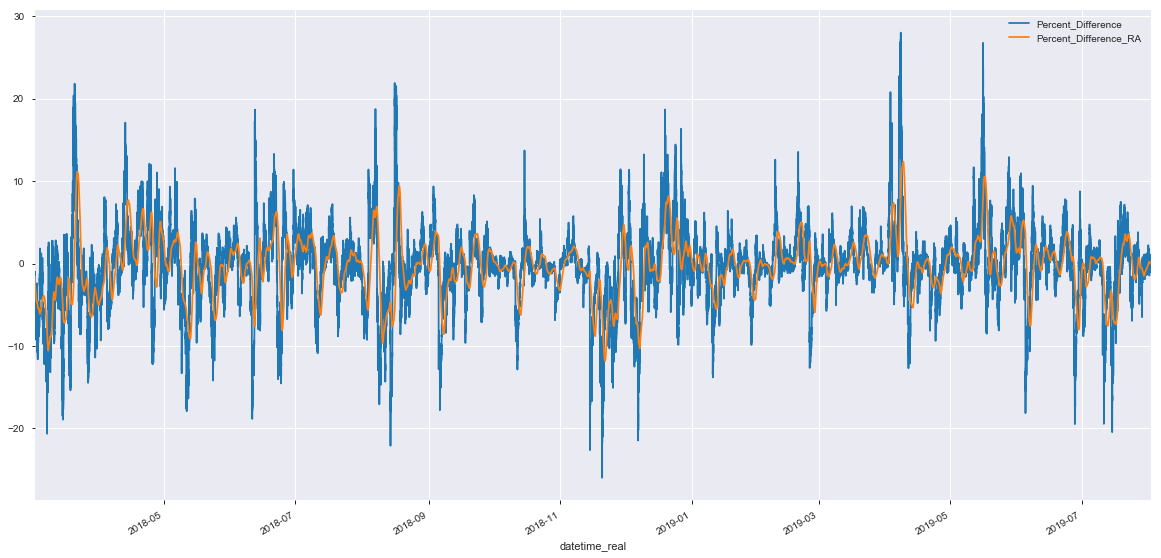

In [110]:
swing_ETH[swing_ETH['datetime_real'] > '2018-03-02'].set_index('datetime_real')[['Percent_Difference','Percent_Difference_RA']].plot(figsize = (20,10))

In [130]:
BTC = []
for myf in open('../Data_storage/BTC_30min_Freq.txt'):
    BTC.append(myf.replace('\n',''))

In [131]:
BTC_Data = []
for E in BTC:
    coin_Temp = pd.read_csv('../Data_storage/Coin_Data_30min/{0}.csv'.format(E))
    BTC_Data.append(coin_Temp)

In [132]:
BTC_Data = pd.concat(BTC_Data)

In [133]:
BTC_Data['datetime_real'] = BTC_Data['date'].apply(lambda x: datetime.fromtimestamp(x))

In [134]:
BTC_Data = BTC_Data[BTC_Data['date'] != 0]

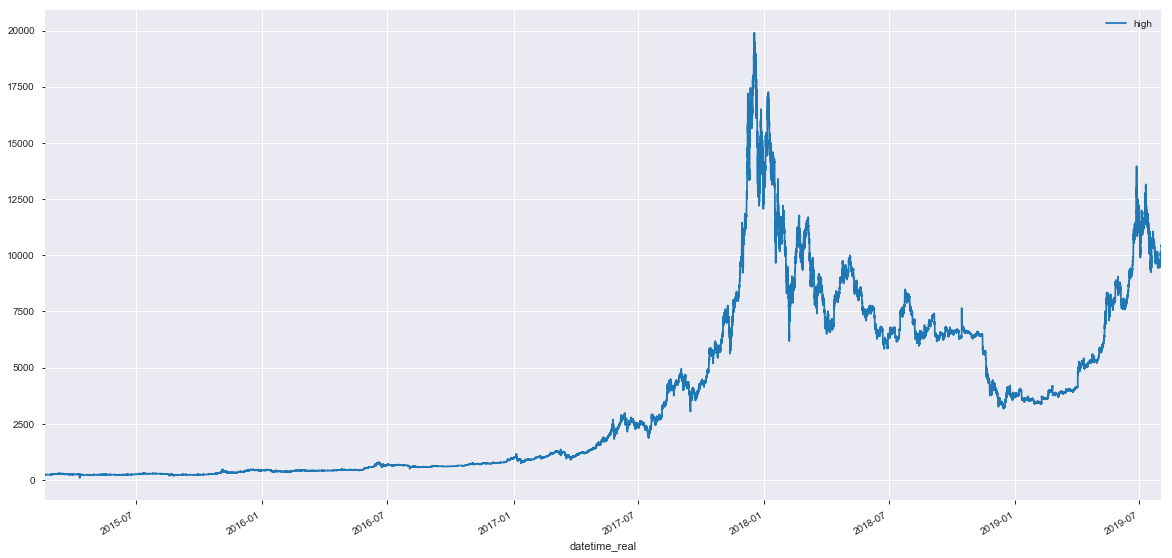

In [135]:
BTC_Data[['high','datetime_real']].set_index('datetime_real').plot(figsize= (20,10))

In [136]:
BTC_Data = BTC_Data.drop(columns = 'Unnamed: 0')

In [137]:
BTC_Data= BTC_Data.drop_duplicates()

In [138]:
pandas_profiling.ProfileReport(BTC_Data)

KeyboardInterrupt: 

In [140]:
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(48).mean()# pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolstd = timeseries.rolling(48).std()# pd.rolling_std(timeseries, window=24)
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [141]:
BTC_Data.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,datetime_real
2587,10411.843688,1564695000,10412.543688,10363.761065,10371.040000,7.569329,78616.453010,10386.185539,2019-08-01 22:30:00
2588,10369.303684,1564696800,10425.018269,10362.000000,10410.000000,7.037109,73281.852989,10413.630111,2019-08-01 23:00:00
2589,10365.000000,1564698600,10378.070000,10362.000000,10375.000000,0.635737,6592.862424,10370.417598,2019-08-01 23:30:00
2590,10393.371188,1564700400,10417.000000,10363.500000,10365.000000,16.803258,174840.979376,10405.183378,2019-08-02 00:00:00
2591,10390.600000,1564702200,10391.801814,10365.700000,10391.365263,2.258918,23429.361882,10371.940103,2019-08-02 00:30:00


In [142]:
rcParams['figure.figsize'] = 20,10

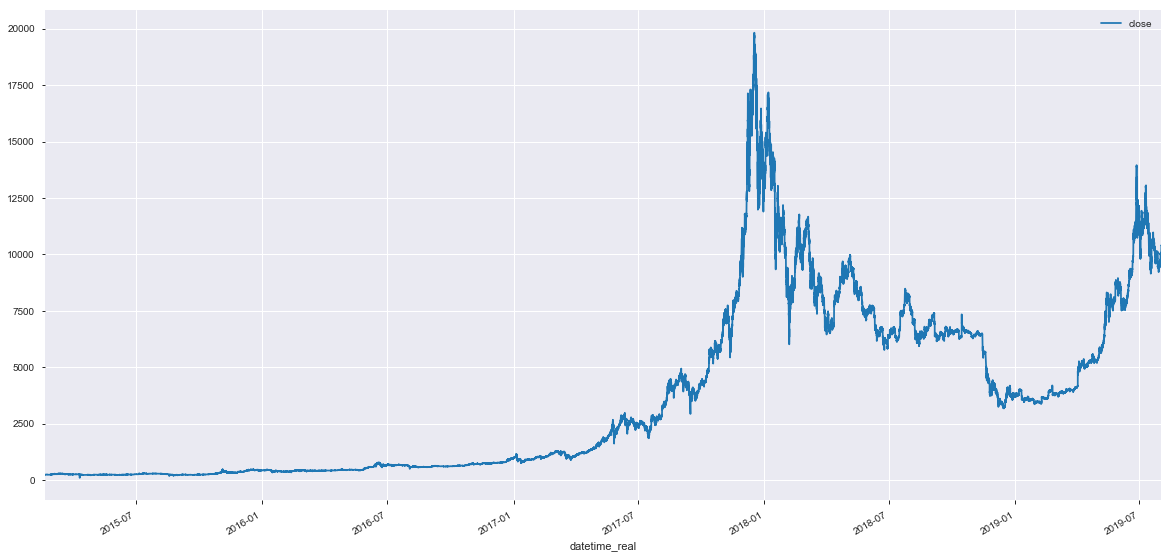

In [143]:
BTC_Data[['close','datetime_real']].set_index('datetime_real').plot()

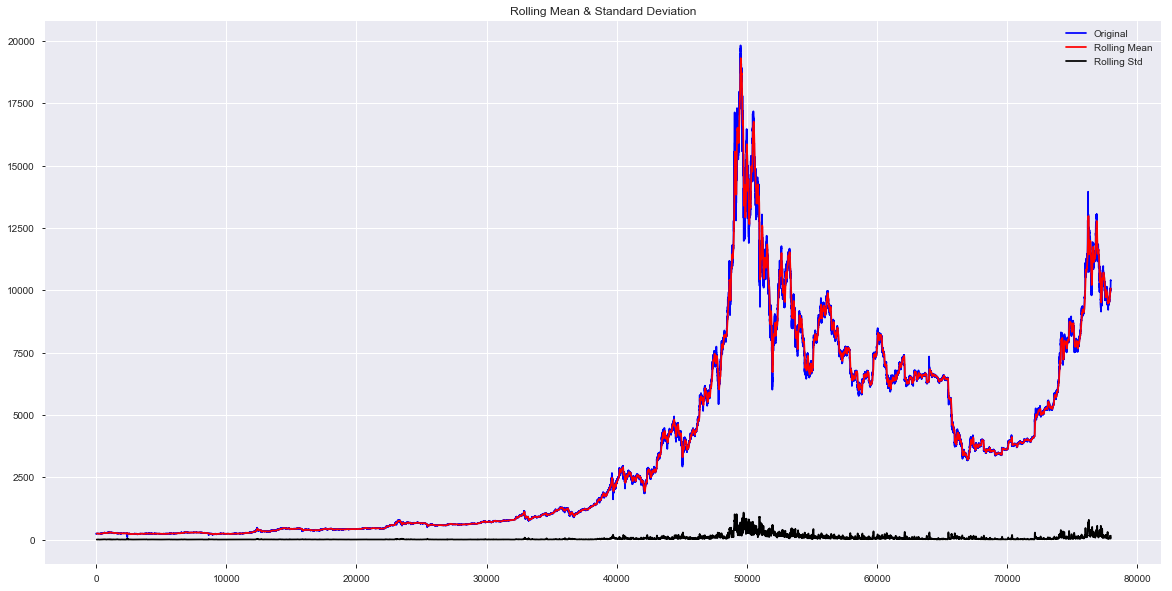

Results of Dickey-Fuller Test:
Test Statistic                    -1.034633
p-value                            0.740424
#Lags Used                        64.000000
Number of Observations Used    77885.000000
Critical Value (1%)               -3.430434
Critical Value (5%)               -2.861577
Critical Value (10%)              -2.566790
dtype: float64


In [180]:
#test_stationarity(train_original['Count'])
test_stationarity(BTC_Data['close'].reset_index()['close'])

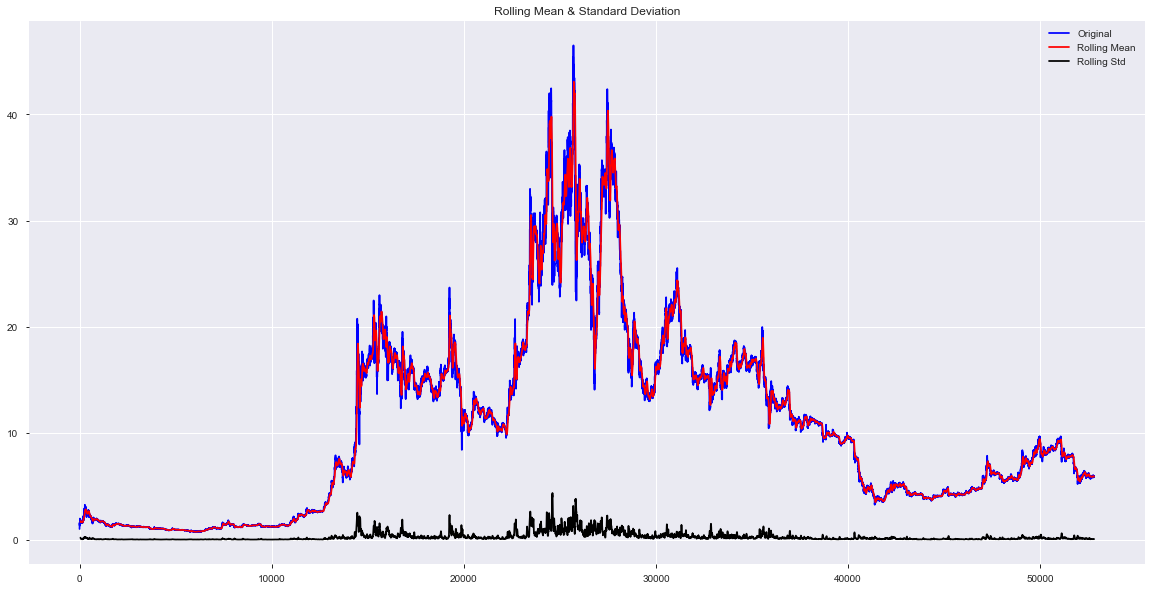

Results of Dickey-Fuller Test:
Test Statistic                    -2.265791
p-value                            0.183238
#Lags Used                        58.000000
Number of Observations Used    52742.000000
Critical Value (1%)               -3.430474
Critical Value (5%)               -2.861595
Critical Value (10%)              -2.566799
dtype: float64


In [181]:
#test_stationarity(train_original['Count'])
test_stationarity(ETH_Data['close'].reset_index()['close'])